## Complete pipeline

## Best Approach

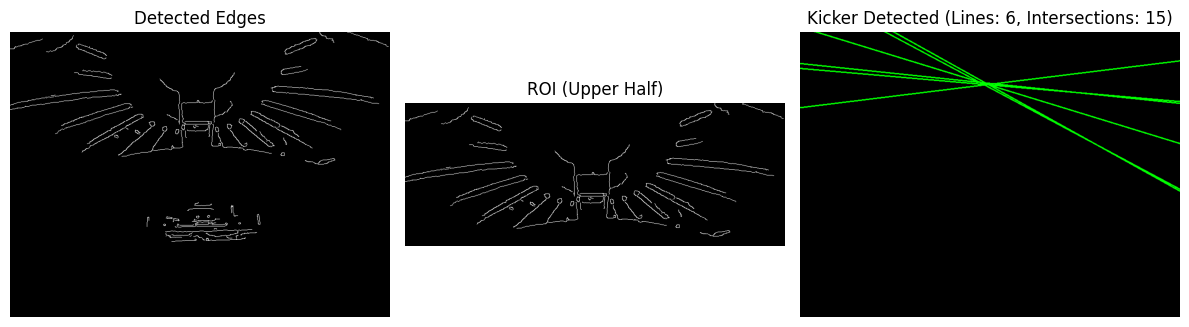

Kicker detected.


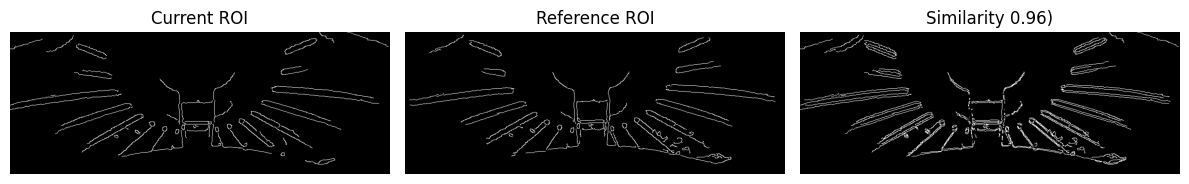

Kicker is in a valid orientation.
Shape Similarity: 82.9736, Similarity Score: 0.9571


True

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Kicker Detection
def detect_kicker(image_path, min_line_count=3, min_intersect_count=2):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return None, None

    # Step 1: Image Preprocessing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 2: Edge Detection
    edges = cv2.Canny(blurred_image, 50, 150)

    # Step 3: Define ROI (upper half of the image)
    height, width = edges.shape
    roi = edges[0:int(height/2), 0:width]

    # Step 4: Pattern Recognition (Hough Transform for lines)
    lines = cv2.HoughLines(roi, 1, np.pi/180, 100)

    # Step 5: Analyze Detected Lines
    kicker_detected = False
    line_image = np.zeros_like(image)
    line_count = 0
    intersect_count = 0
    line_data = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Store line data for intersection check
            line_data.append(((x1, y1), (x2, y2)))
            line_count += 1

    # Step 6: Check if sufficient lines are detected
    if line_count >= min_line_count:
        # Step 7: Check for line intersections to detect kicker-like patterns
        for i in range(len(line_data)):
            for j in range(i + 1, len(line_data)):
                if check_line_intersection(line_data[i], line_data[j]):
                    intersect_count += 1

    # If enough intersections are found, we assume a kicker is detected
    kicker_detected = intersect_count >= min_intersect_count

    # Visualization
    plt.figure(figsize=(12, 10))

    # Edges
    plt.subplot(2, 3, 4)
    plt.imshow(edges, cmap='gray')
    plt.title("Detected Edges")
    plt.axis("off")

    # ROI
    plt.subplot(2, 3, 5)
    plt.imshow(roi, cmap='gray')
    plt.title("ROI (Upper Half)")
    plt.axis("off")

    # Detected Lines (if any)
    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    if kicker_detected:
        plt.title(f"Kicker Detected (Lines: {line_count}, Intersections: {intersect_count})")
    else:
        plt.title("No Kicker Detected")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    if kicker_detected:
        print("Kicker detected.")
        return roi, edges  # Return the ROI and edges for further processing
    else:
        print("No kicker detected.")
        return None, None

# Step 2: Orientation Check
def check_kicker_orientation(current_roi, reference_roi_path, threshold=0.5):
    # Load the reference ROI image
    reference_roi = cv2.imread(reference_roi_path, cv2.IMREAD_GRAYSCALE)
    if reference_roi is None:
        print("Error: Reference ROI not found.")
        return False

    # Step 1: Contour Matching
    current_contours, _ = cv2.findContours(current_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    reference_contours, _ = cv2.findContours(reference_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(current_contours) == 0 or len(reference_contours) == 0:
        print("Error: No contours found in one or both images.")
        return False
    
    current_contour = max(current_contours, key=cv2.contourArea)
    reference_contour = max(reference_contours, key=cv2.contourArea)

    # Match contours using Hu moments
    shape_similarity = cv2.matchShapes(current_contour, reference_contour, cv2.CONTOURS_MATCH_I1, 0.0)
    
    # Step 2: Image Subtraction for ROI comparison
    roi_difference = cv2.absdiff(current_roi, reference_roi)
    similarity_score = 1 - np.mean(roi_difference) / 255

    # Step 3: Visualize the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(current_roi, cmap='gray')
    plt.title("Current ROI")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reference_roi, cmap='gray')
    plt.title("Reference ROI")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(roi_difference, cmap='gray')
    plt.title(f"Similarity {similarity_score:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Decision based on thresholds
    is_valid_orientation = shape_similarity > 70 and similarity_score > threshold
    if is_valid_orientation:
        print("Kicker is in a valid orientation.")
    else:
        print("Kicker is in an invalid orientation.")
    
    print(f"Shape Similarity: {shape_similarity:.4f}, Similarity Score: {similarity_score:.4f}")
    return is_valid_orientation

# Function to check if two lines intersect
def check_line_intersection(line1, line2):
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    (A, B) = line1
    (C, D) = line2
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

# Full pipeline function
def kicker_pipeline(image_path, reference_roi_path, threshold=0.65):
    # Step 1: Detect Kicker
    current_roi, current_edges = detect_kicker(image_path)
    if current_roi is None:
        return False  # No kicker detected

    # Step 2: Check Orientation if kicker detected
    return check_kicker_orientation(current_roi, reference_roi_path, threshold)

# Example usage
image_path = 'image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at front position/Trial 3.jpg'
reference_roi_path = 'Reference_Imgs/reference_roi.jpg'
kicker_pipeline(image_path, reference_roi_path, threshold=0.65)


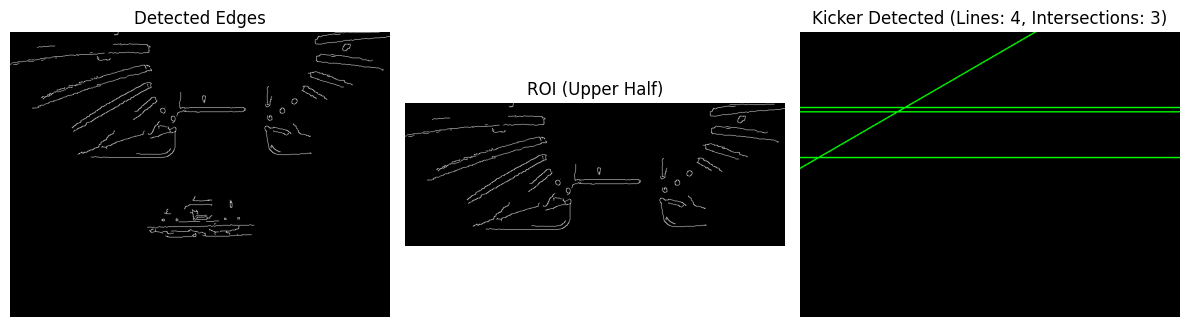

Kicker detected.


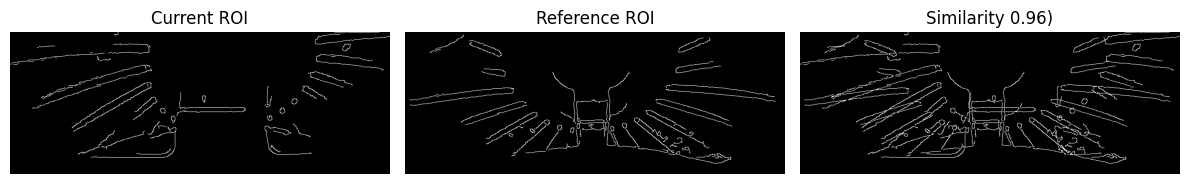

Kicker is in an invalid orientation.
Shape Similarity: 43.9069, Similarity Score: 0.9585


False

In [41]:
# Example usage
image_path = 'image collection/CV Image Collection/03 Kicker Detection/800x600/Invalid Case/Kicker in reverse orientation/Trial 3.jpg'
reference_roi_path = 'Reference_Imgs/reference_roi.jpg'
kicker_pipeline(image_path, reference_roi_path, threshold=0.65)

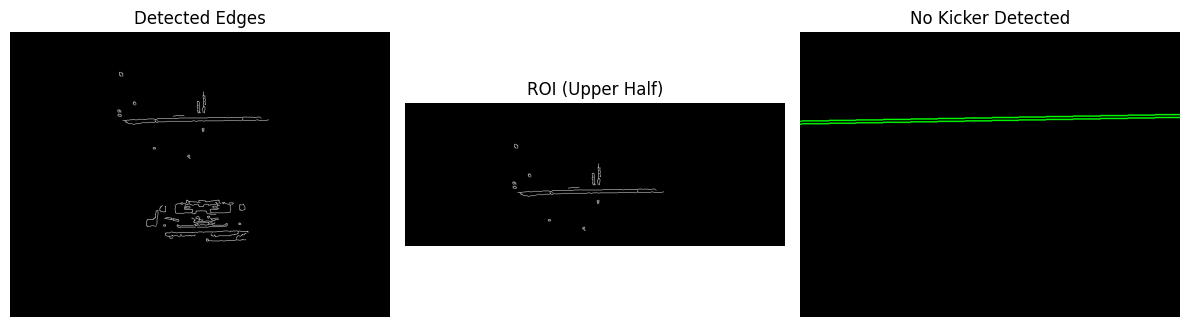

No kicker detected.


False

In [42]:
# Example usage
image_path = 'image collection/CV Image Collection/03 Kicker Detection/800x600/Kicker at pos 100/Trial 1.jpg'
reference_roi_path = 'Reference_Imgs/reference_roi.jpg'
kicker_pipeline(image_path, reference_roi_path, threshold=0.65)